<a href="https://colab.research.google.com/github/Saikowshik007/AI_Job_Predictor/blob/master/CNN_Best_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalMaxPooling1D, Embedding, LSTM
from keras.layers.core import Dense, Dropout, Activation
from keras.preprocessing.text import Tokenizer
from keras import metrics, regularizers
from keras.preprocessing import sequence
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer

In [22]:
#Load cleaned dataset
from google.colab import drive
drive.mount("/content/gdrive")
data = pd.read_csv('/content/gdrive/My Drive/dataset/sample.csv', header = 0, names = ['Query', 'Description'],encoding="utf-8-sig")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [23]:
#Split the dataset to Training and Test subsets (90/10)
train, test = train_test_split(data, test_size = 0.01, random_state = 17)

train_descs = train['Description'].astype("str")
train_labels = train['Query'].astype("str")
 
test_descs = test['Description'].astype("str")
test_labels = test['Query'].astype("str")

In [24]:
# Model Parameters
vocab_size = 1000

sequences_length = 1200

embedding_dimensionality = 64 
max_features = 2000 #equal to vocab_size

num_labels = len(train_labels.unique())
batch_size = 32
nb_epoch = 20

nof_filters = 200
kernel_size = 16

hidden_dims = 512

In [25]:
# Convert Texts to Numeric Vectors for Input
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_descs)

x_train = tokenizer.texts_to_sequences(train_descs)
x_test = tokenizer.texts_to_sequences(test_descs)

x_train = sequence.pad_sequences(x_train, maxlen = sequences_length, padding = 'post')
x_test = sequence.pad_sequences(x_test, maxlen = sequences_length, padding = 'post')

encoder = LabelBinarizer()
encoder.fit(train_labels)
y_train = encoder.transform(train_labels)
y_test = encoder.transform(test_labels)

In [26]:
model = Sequential()
model.add(Embedding(max_features, embedding_dimensionality, input_length = 1200))

model.add(Conv1D(nof_filters, kernel_size, padding='valid', activation='relu', strides = 1))
model.add(GlobalMaxPooling1D())

model.add(Dense(hidden_dims))
model.add(Dropout(0.3))
model.add(Activation('relu'))

model.add(Dense(num_labels))
model.add(Activation('softmax'))

model.summary()
model.compile(loss='categorical_crossentropy', optimizer='adam', #'sgd', 'adam', 'RMSprop', 'Adagrad'
                   metrics = [metrics.categorical_accuracy])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 1200, 64)          128000    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1185, 200)         205000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 200)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               102912    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_2 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 25)               

In [27]:
history = model.fit(x_train, y_train,
                    batch_size = batch_size,
                    epochs = nb_epoch,
                    verbose = True,
                    validation_split = 0.01)

Epoch 1/20
536/536 [==============================] - 10s 18ms/step - loss: 2.3153 - categorical_accuracy: 0.3130 - val_loss: 0.3321 - val_categorical_accuracy: 0.8851
Epoch 2/20
536/536 [==============================] - 9s 18ms/step - loss: 0.3619 - categorical_accuracy: 0.8798 - val_loss: 0.2482 - val_categorical_accuracy: 0.9195
Epoch 3/20
536/536 [==============================] - 9s 17ms/step - loss: 0.2017 - categorical_accuracy: 0.9372 - val_loss: 0.1926 - val_categorical_accuracy: 0.9310
Epoch 4/20
536/536 [==============================] - 9s 18ms/step - loss: 0.1594 - categorical_accuracy: 0.9507 - val_loss: 0.2363 - val_categorical_accuracy: 0.9310
Epoch 5/20
536/536 [==============================] - 9s 18ms/step - loss: 0.1394 - categorical_accuracy: 0.9570 - val_loss: 0.2209 - val_categorical_accuracy: 0.9425
Epoch 6/20
536/536 [==============================] - 9s 18ms/step - loss: 0.1318 - categorical_accuracy: 0.9593 - val_loss: 0.2064 - val_categorical_accuracy: 0.93

In [28]:
score = model.evaluate(x_test, y_test, batch_size = batch_size, verbose = True)
 
print('\nTest categorical_crossentropy:', score[0])
print('Categorical accuracy:', score[1])


6/6 [==============================] - 0s 6ms/step - loss: 0.5632 - categorical_accuracy: 0.9029

Test categorical_crossentropy: 0.5632119178771973
Categorical accuracy: 0.9028571248054504


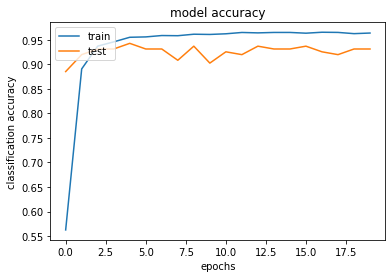

In [29]:
# summarize history for accuracy
import matplotlib.pyplot as plt

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('classification accuracy')
plt.xlabel('epochs')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
model.save( '/content/gdrive/My Drive/dataset/model-cnn.h5' )

In [31]:
import tensorflow as tf

model = tf.keras.models.load_model('/content/gdrive/My Drive/dataset/model-cnn.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("/content/gdrive/My Drive/dataset/converted_model-cnn.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpm0j6dhja/assets


INFO:tensorflow:Assets written to: /tmp/tmpm0j6dhja/assets


1798476

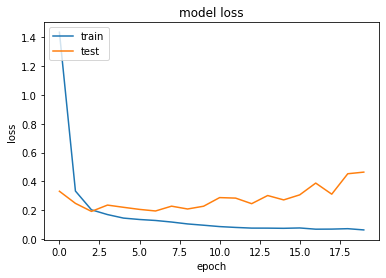

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
text=input()
try:
    predict=model.predict(tokenizer.texts_to_sequences([text]))
    print(predict)
    print(encoder.inverse_transform(predict))
    print(predict.argmax(axis=-1))
except:
    print("Invalid Input")

   Education Bachelor of Technology: Computer Science, 2017- Present GITAM University, Vishakhapatnam CGPA : 8.71/10  Work Experience Computer Repair Technician- Part-Time - 05/2018 to Present Self-Employed, Vishakhapatnam Implemented overclocking CPU an Graphical processing units of computers and Laptops. Conducted custom ROM testing for hardware devices. Repaired phone software on hard bricked phones. Done jailbreaking of iPhones Performed System Operating System Updations and Trouble shooting Upgraded system devices for both laptops and desktop computers Thermal Compound repasting in Computers and Laptops between the components. Internships Technical Assistant - 05/2020 to Present Venture Development Center, North-Eastern University in collab with GITAM, Vishakhapatnam Pitched new product ideas, built and presented the proposals; Discussed, reviewed and evaluated the ideas. Worked on the idea of a prototype to order photocopies online; Designed and tested the prototype Android devel

[[6.0203353e-09 9.9979085e-01 3.9995510e-10 6.3880038e-12 3.4133486e-12
  1.8035316e-12 5.7585051e-11 9.4341141e-07 7.6114514e-12 1.2941230e-09
  1.6374994e-04 4.3537179e-07 2.1210372e-13 1.0793641e-05 5.6328724e-07
  6.5924667e-08 5.8969452e-10 2.5324211e-06 6.7963333e-06 3.8642273e-07
  5.4078587e-08 2.2852690e-05 4.8487202e-08 2.7314576e-12 1.1095518e-09]]
['Android developer']
[1]


In [34]:
import json

with open( '/content/gdrive/My Drive/dataset/dict.json' , 'w' ) as file:
    json.dump( tokenizer.word_index , file )


In [35]:
import tensorflow as tf
interpreter = tf.lite.Interpreter("/content/gdrive/My Drive/dataset/converted_model-cnn.tflite")

In [36]:
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [37]:
output_details

[{'dtype': numpy.float32,
  'index': 19,
  'name': 'Identity',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([ 1, 25], dtype=int32),
  'shape_signature': array([-1, 25], dtype=int32),
  'sparsity_parameters': {}}]

In [38]:
input_details

[{'dtype': numpy.float32,
  'index': 0,
  'name': 'embedding_1_input',
  'quantization': (0.0, 0),
  'quantization_parameters': {'quantized_dimension': 0,
   'scales': array([], dtype=float32),
   'zero_points': array([], dtype=int32)},
  'shape': array([   1, 1200], dtype=int32),
  'shape_signature': array([  -1, 1200], dtype=int32),
  'sparsity_parameters': {}}]

In [39]:
tf.version

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.7/dist-packages/tensorflow/_api/v2/version/__init__.py'>

In [40]:
import tensorflow as tf
from google.colab import drive
drive.mount("/content/gdrive")
interpreter = tf.lite.Interpreter(model_path="/content/gdrive/My Drive/dataset/converted_model-cnn.tflite")
interpreter.allocate_tensors()

# Print input shape and type
inputs = interpreter.get_input_details()
print('{} input(s):'.format(len(inputs)))
for i in range(0, len(inputs)):
    print('{} {}'.format(inputs[i]['shape'], inputs[i]['dtype']))

# Print output shape and type
outputs = interpreter.get_output_details()
print('\n{} output(s):'.format(len(outputs)))
for i in range(0, len(outputs)):
    print('{} {}'.format(outputs[i]['shape'], outputs[i]['dtype']))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
1 input(s):
[   1 1200] <class 'numpy.float32'>

1 output(s):
[ 1 25] <class 'numpy.float32'>
